# Predicting the Best Location to Build a Hotel in Bali
### Applied Data Science Capstone by IBM/Coursera

## Introduction : Business Problem

Bali is one of 34 provinces in Indonesia which is famous for its beautiful beaches. It is not surprising that Bali becomes the most visited destination in Indonesia by tourists, either domestic or foreign tourists. 

As a tourist destination, of course, there are already a lot of hotel in Bali. Therefore, this project will explore districts in south Bali and try to predict the optimal location to build a new hotel. 

This project specifically will be targeted for stakeholders interested in opening a hotel in Southern Bali, Indonesia.

## Data

Data which is be required for this exploration is a list of districts in Bali province, Indonesia. It can be found in Wikipedia from the following link: https://en.wikipedia.org/wiki/Kecamatans_of_Bali. Kecamatan is the Indonesian language means district. Wikipedia articles can be written by anyone, so it could be mistaken happened. Therefore, I use a PDF file from Indonesia’s government website for data verification. Since I am an Indonesian native speaker, so it is easy for me to verify the data which comes from the local language. 

The file for verification can be found in the following link: https://www.kemendagri.go.id/files/2019-05/Kode&Data%20Wilayah/51.bali.fix.pdf.

I do web scraping to acquire a list of districts in Bali using BeautifulSoup package in Python and save it into a CSV file.

For generating latitude and longitude coordinate, I use a Geocoder package in Python.

## Methodology
The stages of this project are started with web scraping, then preparing data, connecting to Foursquare, analyzing data, and clustering. For this project, I am going to explore the venues from the center of the districts as well as the beaches. So, it can be used by stakeholders who would like to build a hotel, either just in south Bali or specifically near a beach. The details of each stage will be discussed in the following.

For district exploration, I separate in two for generating the venues from Foursquare because it involves two island, 8 districts are in Bali island and 1 district is in Nusa Penida island. For the districts in Bali island, I set the radius of 5000 meter or 5 km, while for Nusa Penida island, I set the radius of 13000 meter or 13 km as it covers whole the island.

For beach exploration, I use data from generated-venues in district exploration with filtering the category. I use data that the category is beach and add some beaches which are not in the dataframe yet to optimize the result. The radius I will set is 500 meter from the center of each beach.

In [1]:
import pandas as pd
import csv
import requests
from bs4 import BeautifulSoup
from collections import OrderedDict
import numpy as np
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Get the data from the website

In [2]:
website_url = requests.get('https://en.wikipedia.org/wiki/Kecamatans_of_Bali').text

In [3]:
soup = BeautifulSoup(website_url, 'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Kecamatans of Bali - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"Xfb1ZApAAD4AAHsLW-UAAAFR","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Kecamatans_of_Bali","wgTitle":"Kecamatans of Bali","wgCurRevisionId":917030305,"wgRevisionId":917030305,"wgArticleId":22119307,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["All stub articles","Sunda Islands geography stubs"

In [4]:
my_list = soup.find('div', {'class':'mw-parser-output'}).find_next('ul').find_next('ul').find_next('ul').find_next('ul').find_next('ul').find_next('ul').find_next('ul').find_next('ul').find_next('ul').find_next('ul').find_next('ul').find_next('ul').find_next('ul').find_next('ul')
print(my_list)

<ul><li>Abang, <a href="/wiki/Karangasem_Regency" title="Karangasem Regency">Karangasem</a></li>
<li>Abiansemal, <a href="/wiki/Badung_Regency" title="Badung Regency">Badung</a></li>
<li>Bangli, <a href="/wiki/Bangli_Regency" title="Bangli Regency">Bangli</a></li>
<li>Banjar, <a href="/wiki/Buleleng_Regency" title="Buleleng Regency">Buleleng</a></li>
<li>Banjarankan, <a href="/wiki/Klungkung_Regency" title="Klungkung Regency">Klungkung</a></li>
<li>Baturiti, <a href="/wiki/Tabanan_Regency" title="Tabanan Regency">Tabanan</a></li>
<li>Bebandem, Karangasem</li>
<li>Blahbatuh, <a href="/wiki/Gianyar_Regency" title="Gianyar Regency">Gianyar</a></li>
<li>Buleleng, Buleleng</li>
<li>Busung Biu, Buleleng</li>
<li>Dawan, Klungkung</li>
<li>Denpasar Barat (West Denpasar), <a href="/wiki/Denpasar" title="Denpasar">Denpasar</a></li>
<li>Denpasar Selatan (South Denpasar), Denpasar</li>
<li>Denpasar Timur (East Denpasar), Denpasar</li>
<li>Gerokgak, Buleleng</li>
<li>Gianyar, Gianyar</li>
<li>Karan

Save the data into CSV file

In [5]:
with open('bali_districts.csv', 'w') as csvfile:
    f1 = csv.writer(csvfile)
    for x in my_list:
        data = []
        rows = my_list.find_all('li')
        for i in rows:
            data.append(i.text.strip()) 
    f1.writerow(data)
    
    print('bali_districts.csv was created!')

bali_districts.csv was created!


Read the CSV file

In [6]:
df = pd.read_csv('bali_districts.csv')
df.head()

,"Abang, Karangasem","Abiansemal, Badung","Bangli, Bangli","Banjar, Buleleng","Banjarankan, Klungkung","Baturiti, Tabanan","Bebandem, Karangasem","Blahbatuh, Gianyar","Buleleng, Buleleng","Busung Biu, Buleleng","Dawan, Klungkung","Denpasar Barat (West Denpasar), Denpasar","Denpasar Selatan (South Denpasar), Denpasar","Denpasar Timur (East Denpasar), Denpasar","Gerokgak, Buleleng","Gianyar, Gianyar","Karangasem, Karangasem","Kediri, Tabanan","Kerambitan, Tabanan","Kintamani, Bangli","Klungkung, Klungkung","Kubu, Karangasem","Kubutambahan, Buleleng","Kuta Selatan (South Kuta), Badung","Kuta Utara (North Kuta), Badung","Kuta, Badung","Manggis, Karangasem","Marga, Tabanan","Melaya, Jembrana","Mendoyo, Jembrana","Mengwi, Badung","Negara, Jembrana","Nusa Penida, Klungkung","Payangan, Gianyar","Pekutatan, Jembrana","Penebel, Tabanan","Petang, Badung","Pupuan, Tabanan","Rendang, Karangasem","Sawan, Buleleng","Selat, Karangasem","Selemadeg Bara, Tabanan","Selemadeg Barat (West Selemadeg), Tabanan","Selemadeg Timur (East Selemadeg), Tabanan","Selemadeg, Tabanan","Seririt, Buleleng","Sidemen, Karangasem","Sukasada, Buleleng","Sukawati, Gianyar","Susut, Bangli","Tabanan, Tabanan","Tampaksiring, Gianyar","Tegallalang, Gianyar","Tejakula, Buleleng","Tembuku, Bangli","Ubud, Gianyar."


As you can see, data displayed in the dataframe still does not in appropriate form. The name of districts indexed as column names, so let's perform dataframe transposing to change the name of districts as rows

In [7]:
df = df.transpose().reset_index()
df.head()

,index
0,"Abang, Karangasem"
1,"Abiansemal, Badung"
2,"Bangli, Bangli"
3,"Banjar, Buleleng"
4,"Banjarankan, Klungkung"


Now, rename the index column as District

In [8]:
df = df.rename(columns={'index' : 'District'})
df.head()

,District
0,"Abang, Karangasem"
1,"Abiansemal, Badung"
2,"Bangli, Bangli"
3,"Banjar, Buleleng"
4,"Banjarankan, Klungkung"


The string in the dataframe still in form ***district, regency***. Let's split the string to make it clear which one is the districts and which one is the regencies then put the regencies in a new column named Regency.

In [9]:
df['Regency'] = df['District'].str.rsplit(', ',1).str[1]
df['District'] = df['District'].str.rsplit(', ',1).str[0]
df.head()

,District,Regency
0,Abang,Karangasem
1,Abiansemal,Badung
2,Bangli,Bangli
3,Banjar,Buleleng
4,Banjarankan,Klungkung


Let's count the number of rows in the dataframe

In [10]:
df.count()

District    56
Regency     56
dtype: int64

Now, let's take a look number of districts in each regency and do the verification whether we have used the right data or not. I compare this with the data from Indonesia government provided in the link I share above.

In [11]:
df['Regency'].value_counts()

Tabanan       11
Buleleng       9
Karangasem     8
Badung         6
Gianyar        6
Bangli         4
Jembrana       4
Klungkung      4
Denpasar       3
Gianyar.       1
Name: Regency, dtype: int64

After I verified it with data from Indonesia government, I found some mismatches between the two data such as a mismatch between district and regency, a missed district, a should-not-be-there district, and some typo cases. Now, let's fix the dataframe.

First, add the data which do not in the dataframe.

In [12]:
add_data = [('Denpasar Utara (North Denpasar)', 'Denpasar'),
            ('Jembrana', 'Jembrana')]

data = pd.DataFrame(add_data, columns = ['District', 'Regency'])
df = df.append(data, ignore_index=False)
df = df.sort_values(by='District').reset_index(drop=True)
df

,District,Regency
0,Abang,Karangasem
1,Abiansemal,Badung
2,Bangli,Bangli
3,Banjar,Buleleng
4,Banjarankan,Klungkung
5,Baturiti,Tabanan
6,Bebandem,Karangasem
7,Blahbatuh,Gianyar
8,Buleleng,Buleleng
9,Busung Biu,Buleleng


Next, replace the values with the right one and drop the district which should not be there.

In [13]:
df.District.replace(to_replace = 'Banjarankan', value = 'Banjarangkan', inplace=True)
df.Regency.replace(to_replace = 'Gianyar.', value = 'Gianyar', inplace=True)
df = df.drop(df[df.District == 'Selemadeg Bara'].index).reset_index(drop=True)
df

,District,Regency
0,Abang,Karangasem
1,Abiansemal,Badung
2,Bangli,Bangli
3,Banjar,Buleleng
4,Banjarangkan,Klungkung
5,Baturiti,Tabanan
6,Bebandem,Karangasem
7,Blahbatuh,Gianyar
8,Buleleng,Buleleng
9,Busung Biu,Buleleng


Let's see the result

In [14]:
df['Regency'].value_counts()

Tabanan       10
Buleleng       9
Karangasem     8
Gianyar        7
Badung         6
Jembrana       5
Bangli         4
Klungkung      4
Denpasar       4
Name: Regency, dtype: int64

In [15]:
df.count()

District    57
Regency     57
dtype: int64

I also shorthen the values having the English translation

In [16]:
df.District.replace(to_replace = 'Denpasar Barat (West Denpasar)', value = 'Denpasar Barat', inplace=True)
df.District.replace(to_replace = 'Denpasar Selatan (South Denpasar)', value = 'Denpasar Selatan', inplace=True)
df.District.replace(to_replace = 'Denpasar Timur (East Denpasar)', value = 'Denpasar Timur', inplace=True)
df.District.replace(to_replace = 'Denpasar Utara (North Denpasar)', value = 'Denpasar Utara', inplace=True)
df.District.replace(to_replace = 'Kuta Selatan (South Kuta)', value = 'Kuta Selatan', inplace=True)
df.District.replace(to_replace = 'Kuta Utara (North Kuta)', value = 'Kuta Utara', inplace=True)
df.District.replace(to_replace = 'Selemadeg Barat (West Selemadeg)', value = 'Salemadeg Barat', inplace=True)
df.District.replace(to_replace = 'Selemadeg Timur (East Selemadeg)', value = 'Salemadeg Timur', inplace=True)
df

,District,Regency
0,Abang,Karangasem
1,Abiansemal,Badung
2,Bangli,Bangli
3,Banjar,Buleleng
4,Banjarangkan,Klungkung
5,Baturiti,Tabanan
6,Bebandem,Karangasem
7,Blahbatuh,Gianyar
8,Buleleng,Buleleng
9,Busung Biu,Buleleng


Now, we have the right data for exploration. The next step is to save this data into a new CSV file.

In [17]:
df.to_csv('fixed_bali_districts.csv')

Because I would like to explore the disticts only in south Bali, I just include 9 districts for this exploration.

In [18]:
districts = ['Kuta', 'Kuta Selatan', 'Kuta Utara', 'Denpasar Selatan', 'Denpasar Utara', 'Denpasar Timur', 'Denpasar Barat', 'Nusa Penida', 'Kediri']

df = df[df['District'].isin(districts)].reset_index(drop=True)
df

,District,Regency
0,Denpasar Barat,Denpasar
1,Denpasar Selatan,Denpasar
2,Denpasar Timur,Denpasar
3,Denpasar Utara,Denpasar
4,Kediri,Tabanan
5,Kuta,Badung
6,Kuta Selatan,Badung
7,Kuta Utara,Badung
8,Nusa Penida,Klungkung


Now, let's generate the latitude and longitude coordinates

In [19]:
geolocator = Nominatim(user_agent="my_explorer")

df['Latitude'] = df['District'].apply(geolocator.geocode, timeout=20).apply(lambda x: x.latitude)
df['Longitude'] = df['District'].apply(geolocator.geocode, timeout=20).apply(lambda x: x.longitude)
df

,District,Regency,Latitude,Longitude
0,Denpasar Barat,Denpasar,-8.662244,115.198067
1,Denpasar Selatan,Denpasar,-8.706134,115.225676
2,Denpasar Timur,Denpasar,-8.632914,115.246211
3,Denpasar Utara,Denpasar,-8.624513,115.209009
4,Kediri,Tabanan,-7.805898,112.168507
5,Kuta,Badung,-8.727835,115.173005
6,Kuta Selatan,Badung,-8.808849,115.169528
7,Kuta Utara,Badung,5.067268,97.041101
8,Nusa Penida,Klungkung,-8.745652,115.534745


As we can see above, it looks like Kediri and Kuta Utara did not generate the coordinates properly. Now, let's generate those coordinates individually with define more specific address.

In [20]:
geolocator = Nominatim(user_agent="my_explorer")
location = geolocator.geocode('Kediri, Bali', timeout=20)
kediri_latitude = location.latitude
kediri_longitude = location.longitude
print('The geograpical coordinate of Kediri, Bali are {}, {}.'.format(kediri_latitude, kediri_longitude))

The geograpical coordinate of Kediri, Bali are -8.5644545, 115.1320721.


In [21]:
geolocator = Nominatim(user_agent="my_explorer")
location = geolocator.geocode('Kuta Utara, Bali', timeout=20)
kuta_utara_latitude = location.latitude
kuta_utara_longitude = location.longitude
print('The geograpical coordinate of Kuta Utara, Bali are {}, {}.'.format(kuta_utara_latitude, kuta_utara_longitude))

The geograpical coordinate of Kuta Utara, Bali are -8.6780422, 115.1698611.


Let's insert those results to the dataframe

In [22]:
df.loc[df['District'] == 'Kediri', ['Latitude','Longitude']] = [kediri_latitude, kediri_longitude]
df.loc[df['District'] == 'Kuta Utara', ['Latitude','Longitude']] = [kuta_utara_latitude, kuta_utara_longitude]
df

,District,Regency,Latitude,Longitude
0,Denpasar Barat,Denpasar,-8.662244,115.198067
1,Denpasar Selatan,Denpasar,-8.706134,115.225676
2,Denpasar Timur,Denpasar,-8.632914,115.246211
3,Denpasar Utara,Denpasar,-8.624513,115.209009
4,Kediri,Tabanan,-8.564455,115.132072
5,Kuta,Badung,-8.727835,115.173005
6,Kuta Selatan,Badung,-8.808849,115.169528
7,Kuta Utara,Badung,-8.678042,115.169861
8,Nusa Penida,Klungkung,-8.745652,115.534745


Now, I will generate map of Bali using folium. So, I need the coordinates of Bali

In [23]:
address = 'Bali, Indonesia'

geolocator = Nominatim(user_agent="my_explorer")
location = geolocator.geocode(address, timeout=20)
bali_latitude = location.latitude
bali_longitude = location.longitude
print('The geograpical coordinate of Bali are {}, {}.'.format(bali_latitude, bali_longitude))

The geograpical coordinate of Bali are -8.3304977, 115.0906401.


In [24]:
# create map of Bali using latitude and longitude values
map_bali = folium.Map(location=[bali_latitude, bali_longitude], zoom_start=9)

# add markers to map
for lat, lng, district, regency in zip(df['Latitude'], df['Longitude'], df['District'], df['Regency']):
    label = '{}, {}'.format(district, regency)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bali)  
    
map_bali.save('bali_map.html')    
map_bali

## Connect to Foursquare

In [25]:
CLIENT_ID = 'QGPLMTPPGNBAGNTFZQ1WRL3OABORRQ52O5SMGTXMFJZUOUHR' # your Foursquare ID
CLIENT_SECRET = 'HRQFV3VDCZTYIKMP0GCSRBW3MMDBN5LCGXB0FM4WRWLWBSYJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QGPLMTPPGNBAGNTFZQ1WRL3OABORRQ52O5SMGTXMFJZUOUHR
CLIENT_SECRET:HRQFV3VDCZTYIKMP0GCSRBW3MMDBN5LCGXB0FM4WRWLWBSYJ


In [26]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    limit = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    return(nearby_venues)

## Generate venues in southern Bali island

Because of the districts are located in two islands, 8 districts in Bali island and 1 district in Nusa Penida island, I separate it in generating the venues. For 8 districts in Bali island, I set the radius of 5 km or 5000 meter from the center of each district.

In [28]:
south_bali_venues = getNearbyVenues(names=df['District'][0:8],
                                    latitudes=df['Latitude'][0:8],
                                    longitudes=df['Longitude'][0:8],
                                    radius=5000
                                   )

Denpasar Barat
Denpasar Selatan
Denpasar Timur
Denpasar Utara
Kediri
Kuta
Kuta Selatan
Kuta Utara


In [29]:
south_bali_venues.columns = ['District', 
              'District Latitude', 
              'District Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']

print(south_bali_venues.shape)
south_bali_venues

(739, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Denpasar Barat,-8.662244,115.198067,Bebek Goreng H.Slamet,-8.670825,115.191436,Indonesian Restaurant
1,Denpasar Barat,-8.662244,115.198067,Quest San Hotel Denpasar,-8.677209,115.190134,Hotel
2,Denpasar Barat,-8.662244,115.198067,Bakso Soto IMBO,-8.659310,115.209071,Breakfast Spot
3,Denpasar Barat,-8.662244,115.198067,Kopi Bali Cap Kupu-Kupu Bola Dunia,-8.655491,115.213394,Coffee Shop
4,Denpasar Barat,-8.662244,115.198067,Indoraya Grosir,-8.671957,115.208982,Mobile Phone Shop
5,Denpasar Barat,-8.662244,115.198067,"Depot Umum ""Batan Sabo""",-8.658079,115.214675,Chinese Restaurant
6,Denpasar Barat,-8.662244,115.198067,Balinese Therapy Massage,-8.666056,115.215917,Spa
7,Denpasar Barat,-8.662244,115.198067,Marugame Udon,-8.676021,115.207144,Noodle House
8,Denpasar Barat,-8.662244,115.198067,9/11 Cafe & Concept Store,-8.681070,115.188435,Bistro
9,Denpasar Barat,-8.662244,115.198067,Garuda Indonesia Denpasar,-8.658517,115.218065,Office


Now, let's take a look at the number of venues for each district

In [30]:
south_bali_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Denpasar Barat,100,100,100,100,100,100
Denpasar Selatan,100,100,100,100,100,100
Denpasar Timur,100,100,100,100,100,100
Denpasar Utara,100,100,100,100,100,100
Kediri,39,39,39,39,39,39
Kuta,100,100,100,100,100,100
Kuta Selatan,100,100,100,100,100,100
Kuta Utara,100,100,100,100,100,100


Let's see how many unique categories are in south Bali

In [31]:
print('There are {} uniques categories in South Bali.'.format(len(south_bali_venues['Venue Category'].unique())))

There are 140 uniques categories in South Bali.


## Generate venues in Nusa Penida island

For Nusa Penida island, I set the radius of 13 km or 13000 meter from its center because it covers whole the island.

In [32]:
dist_latitude = df.loc[8, 'Latitude'] # district latitude value
dist_longitude = df.loc[8, 'Longitude'] # district longitude value
dist_name = df.loc[8, 'District'] # district name

print('Latitude and longitude values of {} are {}, {}.'.format(dist_name, 
                                                               dist_latitude, 
                                                               dist_longitude))

Latitude and longitude values of Nusa Penida are -8.74565245, 115.534744961883.


In [33]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 13000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    dist_latitude, 
    dist_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=QGPLMTPPGNBAGNTFZQ1WRL3OABORRQ52O5SMGTXMFJZUOUHR&client_secret=HRQFV3VDCZTYIKMP0GCSRBW3MMDBN5LCGXB0FM4WRWLWBSYJ&v=20180605&ll=-8.74565245,115.534744961883&radius=13000&limit=100'

In [34]:
results = requests.get(url).json()

In [35]:
venues = results['response']['groups'][0]['items']
    
nusa_penida_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nusa_penida_venues = nusa_penida_venues.loc[:, filtered_columns]

# filter the category for each row
nusa_penida_venues['venue.categories'] = nusa_penida_venues.apply(get_category_type, axis=1)

# clean columns
nusa_penida_venues.columns = ['Venue', 'Venue Category', 'Venue Latitude', 'Venue Longitude']

print(nusa_penida_venues.shape)
nusa_penida_venues

(73, 4)


,Venue,Venue Category,Venue Latitude,Venue Longitude
0,Peguyangan Waterfalls,Waterfall,-8.781282,115.517186
1,Kelingking Beach,Beach,-8.750886,115.475774
2,Penida Colada,Beach Bar,-8.676435,115.514370
3,Crystal Bay,Beach,-8.715771,115.458927
4,Angel's Billabong,Scenic Lookout,-8.733337,115.448826
5,Broken Beach (Pasih Uug),Scenic Lookout,-8.732653,115.450927
6,Secret Penida Cafe,Café,-8.677506,115.526102
7,Le Pirate Beach Club,Resort,-8.700540,115.443122
8,Warung Putu,Indonesian Restaurant,-8.693702,115.447575
9,Mangrove Beach,Beach,-8.666345,115.464161


Let's take a look at the unique categories are in it.

In [36]:
print('There are {} uniques categories in Nusa Penida.'.format(len(nusa_penida_venues['Venue Category'].unique())))

There are 25 uniques categories in Nusa Penida.


## Analyzing Data - Around the District

First, let's concatenate the result of generating venues in Bali island and Nusa Penida island

In [37]:
bali_venues = pd.concat([south_bali_venues, nusa_penida_venues], axis=0, sort=True).reset_index(drop=True)
bali_venues = bali_venues.drop(['District Latitude', 'District Longitude'], axis=1)
bali_venues = bali_venues.fillna('Nusa Penida')
print(bali_venues.shape)
bali_venues

(812, 5)


,District,Venue,Venue Category,Venue Latitude,Venue Longitude
0,Denpasar Barat,Bebek Goreng H.Slamet,Indonesian Restaurant,-8.670825,115.191436
1,Denpasar Barat,Quest San Hotel Denpasar,Hotel,-8.677209,115.190134
2,Denpasar Barat,Bakso Soto IMBO,Breakfast Spot,-8.659310,115.209071
3,Denpasar Barat,Kopi Bali Cap Kupu-Kupu Bola Dunia,Coffee Shop,-8.655491,115.213394
4,Denpasar Barat,Indoraya Grosir,Mobile Phone Shop,-8.671957,115.208982
5,Denpasar Barat,"Depot Umum ""Batan Sabo""",Chinese Restaurant,-8.658079,115.214675
6,Denpasar Barat,Balinese Therapy Massage,Spa,-8.666056,115.215917
7,Denpasar Barat,Marugame Udon,Noodle House,-8.676021,115.207144
8,Denpasar Barat,9/11 Cafe & Concept Store,Bistro,-8.681070,115.188435
9,Denpasar Barat,Garuda Indonesia Denpasar,Office,-8.658517,115.218065


Now, let's count the unique categories from concatenated data

In [38]:
print('There are {} uniques categories in Bali and Nusa Penida island.'.format(len(bali_venues['Venue Category'].unique())))

There are 145 uniques categories in Bali and Nusa Penida island.


The first exploration is to know what category of venues is the most common in south Bali. As we know, there are 812 venues all around the districts with 145 unique categories. The first step to do is to count the number of venues grouped by each category. Then, sorting in ascending is performed based on the number of venues. Not all of the categories to be displayed, only the top 15 categories displayed.

In [39]:
bali_venues_count = bali_venues.groupby(['Venue Category'])['Venue'].count().reset_index()
bali_venues_count = bali_venues_count.sort_values(by='Venue', ascending=True)
bali_venues_count.set_index('Venue Category', inplace=True)
bali_top15 = bali_venues_count['Venue'].tail(15)
bali_top15

Venue Category
Seafood Restaurant       13
Pizza Place              13
Italian Restaurant       13
Spa                      15
Chinese Restaurant       17
BBQ Joint                20
Restaurant               21
Bakery                   23
Beach                    24
Asian Restaurant         25
Café                     30
Coffee Shop              45
Resort                   47
Hotel                    55
Indonesian Restaurant    79
Name: Venue, dtype: int64

Now, let's visualize it in Bar chart

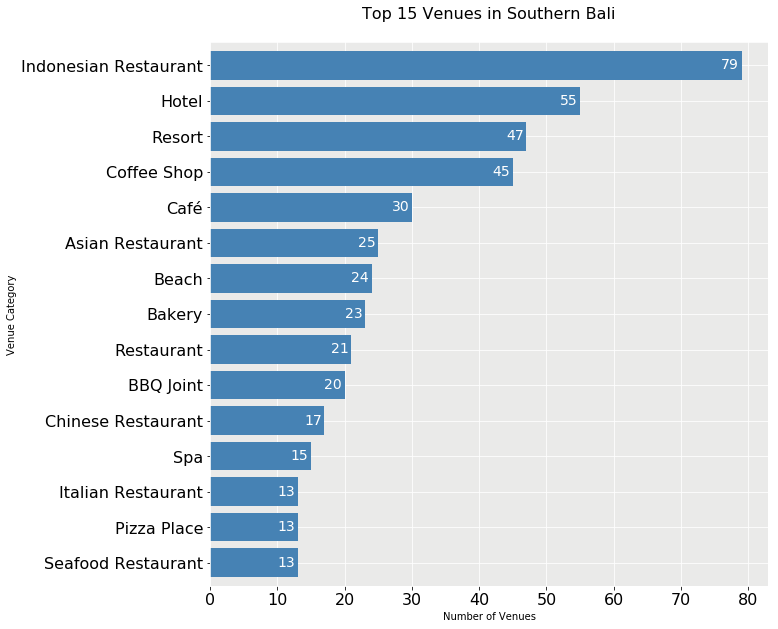

In [41]:
# generate plot
bali_top15.plot(kind='barh', figsize=(10, 10), color='steelblue', width=0.8)
plt.xlabel('Number of Venues')
plt.title('Top 15 Venues in Southern Bali\n', fontsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

# annotate value labels to each country
for index, value in enumerate(bali_top15): 
    label = format(int(value)) # format int with commas
    
    # place text at the end of bar (subtracting 2 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value - 3, index - 0.10), color='white', fontsize=14)

plt.rcParams['axes.facecolor'] = '#eaeae9'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "white"

plt.savefig('top15_venues_in_southern_bali.jpg', bbox_inches = "tight")
plt.show()

Now, let's focus on category of hotel as we want to predict the best location for a hotel. First, filter the venues having category of hotel in the dataframe.

In [42]:
hotel_bali = bali_venues[bali_venues['Venue Category'] == 'Hotel']
print(hotel_bali.shape)
hotel_bali

(55, 5)


,District,Venue,Venue Category,Venue Latitude,Venue Longitude
1,Denpasar Barat,Quest San Hotel Denpasar,Hotel,-8.677209,115.190134
32,Denpasar Barat,Amaris Hotel Teuku Umar,Hotel,-8.680730,115.202952
63,Denpasar Barat,Ramada,Hotel,-8.685195,115.176169
78,Denpasar Barat,Daun Bali Seminyak,Hotel,-8.672361,115.163736
98,Denpasar Barat,Santika Hotel Seminyak,Hotel,-8.690226,115.173421
117,Denpasar Selatan,Taksu Hotel Sanur,Hotel,-8.705885,115.255979
133,Denpasar Selatan,Mercure Resort Sanur Bali,Hotel,-8.709372,115.253974
136,Denpasar Selatan,Prama Sanur Beach Hotel,Hotel,-8.709834,115.256470
145,Denpasar Selatan,Puri Santrian Hotel,Hotel,-8.709111,115.258073
146,Denpasar Selatan,Artotel Sanur - Bali,Hotel,-8.705484,115.260947


Now, let's count the number of hotels for each district. As we can see above, there are two districts which do not have any single hotel. For better understanding, I define the 0 value for those districts.

In [43]:
hotel_bali_count = hotel_bali.groupby('District')['Venue'].count().reset_index()
hotel_bali_count = hotel_bali_count.append([{'District': 'Denpasar Utara', 'Venue': 0}, 
                                            {'District': 'Kediri', 'Venue': 0}])

hotel_bali_count = hotel_bali_count.sort_values(by='Venue', ascending=True)
hotel_bali_count.set_index('District', inplace=True)
hotel_bali_count = hotel_bali_count['Venue'].tail(10)
hotel_bali_count

District
Denpasar Utara       0
Kediri               0
Denpasar Timur       1
Denpasar Barat       5
Kuta Selatan         5
Nusa Penida          5
Denpasar Selatan     9
Kuta Utara          12
Kuta                18
Name: Venue, dtype: int64

From the result above, let's generate a bar chart for better understanding

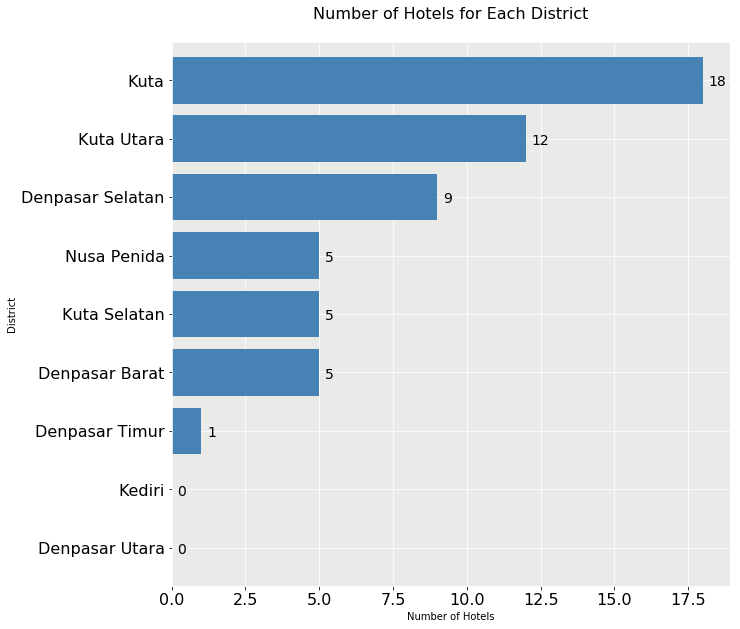

In [44]:
# generate plot
hotel_bali_count.plot(kind='barh', figsize=(10, 10), color='steelblue', width=0.8)
plt.xlabel('Number of Hotels')
plt.title('Number of Hotels for Each District\n', fontsize=16)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

# annotate value labels to each country
for index, value in enumerate(hotel_bali_count): 
    label = format(int(value)) # format int with commas
    
    # place text at the end of bar (subtracting 2 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value + 0.2, index - 0.10), color='black', fontsize=14)

plt.rcParams['axes.facecolor'] = '#eaeae9'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "white"

plt.savefig('number_of_hotels_in_each_district.jpg', bbox_inches = "tight")
plt.show()

## Clustering the districts

Clustering data is to group similar objects into a set known as cluster. This process is used to get some cluster contain similarity of venues they have. For this project, the K-Means algorithm is used as a method to get some clusters.

As we would like to know the similarity of districts, we have to know what venues the most are in each district. The first step to do is to encode the venue categories using one-hot encoding method. It turns out value 0 or 1 in venue categories for each venue.

In [45]:
# one hot encoding
bali_encoding = pd.get_dummies(bali_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
bali_encoding['District'] = bali_venues['District'] 

bali_encoding.head()

,Accessories Store,Airport Lounge,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Balinese Restaurant,Bar,Beach,Beach Bar,Bed & Breakfast,Big Box Store,Bistro,Boarding House,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Bus Station,Café,Candy Store,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Shop,Dive Spot,Donut Shop,Eastern European Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gastropub,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health Food Store,High School,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Meatball Place,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Lounge,Market,Massage Studio,Mexican Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Multiplex,Museum,Music Venue,Nail Salon,Nightclub,Noodle House,Office,Other Great Outdoors,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pie Shop,Pizza Place,Plaza,Pool,Resort,Rest Area,Restaurant,Salad Place,Satay Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soup Place,Spa,Sports Club,Steakhouse,Sundanese Restaurant,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Temple,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfall,Wine Bar,Wings Joint,Women's Store,Yoga Studio,District
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Denpasar Barat
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Denpasar Barat
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Denpasar Barat
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Denpasar Barat
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Denpasar Barat


Let's move the district to the first column

In [46]:
# move district to the first column
fixed_column = [bali_encoding.columns[-1]] + list(bali_encoding.columns[0:-1])
bali_encoding = bali_encoding[fixed_column]

bali_encoding.head()

,District,Accessories Store,Airport Lounge,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Balinese Restaurant,Bar,Beach,Beach Bar,Bed & Breakfast,Big Box Store,Bistro,Boarding House,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Bus Station,Café,Candy Store,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Shop,Dive Spot,Donut Shop,Eastern European Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gastropub,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health Food Store,High School,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Meatball Place,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Lounge,Market,Massage Studio,Mexican Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Multiplex,Museum,Music Venue,Nail Salon,Nightclub,Noodle House,Office,Other Great Outdoors,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pie Shop,Pizza Place,Plaza,Pool,Resort,Rest Area,Restaurant,Salad Place,Satay Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soup Place,Spa,Sports Club,Steakhouse,Sundanese Restaurant,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Temple,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfall,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Denpasar Barat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Denpasar Barat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Denpasar Barat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Denpasar Barat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Denpasar Barat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
bali_encoding.shape

(812, 146)

Once we get the encoding dataframe, the next step is to calculate the average or mean for each venue grouped by the district.

In [48]:
bali_grouped = bali_encoding.groupby('District').mean().reset_index()
bali_grouped

,District,Accessories Store,Airport Lounge,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Balinese Restaurant,Bar,Beach,Beach Bar,Bed & Breakfast,Big Box Store,Bistro,Boarding House,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Bus Station,Café,Candy Store,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Shop,Dive Spot,Donut Shop,Eastern European Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gastropub,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health Food Store,High School,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Meatball Place,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Lounge,Market,Massage Studio,Mexican Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Multiplex,Museum,Music Venue,Nail Salon,Nightclub,Noodle House,Office,Other Great Outdoors,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pie Shop,Pizza Place,Plaza,Pool,Resort,Rest Area,Restaurant,Salad Place,Satay Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soup Place,Spa,Sports Club,Steakhouse,Sundanese Restaurant,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Temple,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfall,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Denpasar Barat,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.040000,0.00,0.020000,0.00,0.00,0.040000,0.00,0.000000,0.000000,0.000000,0.010000,0.00,0.02,0.000000,0.00,0.000000,0.00,0.010000,0.00,0.00,0.000000,0.000000,0.000000,0.010000,0.00,0.040000,0.01,0.010000,0.00,0.070000,0.00,0.010000,0.00,0.000000,0.00,0.00,0.02,0.00,0.000000,0.000000,0.020000,0.010000,0.00,0.000000,0.000000,0.01,0.000000,0.020000,0.000000,0.010000,0.00,0.00,0.01,0.01,0.00,0.01,0.000000,0.02,0.00,0.02,0.00,0.010000,0.00,0.00,0.00,0.050000,0.00,0.03,0.00,0.01,0.00,0.150000,0.01,0.02,0.03,0.00,0.01,0.02,0.00,0.01,0.000000,0.000000,0.00,0.00,0.01,0.00,0.01,0.000000,0.01,0.00,0.000000,0.00,0.00,0.00,0.02,0.01,0.000000,0.00,0.00,0.00,0.00,0.00,0.01,0.03,0.00,0.00,0.010000,0.000000,0.030000,0.01,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.01,0.010000,0.00,0.020000,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00
1,Denpasar Selatan,0.00,0.00,0.010000,0.000000,0.01,0.00,0.00,0.030000,0.00,0.010000,0.01,0.00,0.040000,0.01,0.010000,0.020000,0.010000,0.000000,0.00,0.02,0.000000,0.00,0.010000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.060000,0.00,0.010000,0.01,0.010000,0.00,0.050000,0.00,0.010000,0.01,0.000000,0.00,0.01,0.02,0.01,0.030000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.01,0.00,0.01,0.00,0.000000,0.00,0.01,0.00,0.090000,0.00,0.00,0.01,0.00,0.01,0.080000,0.01,0.00,0.01,0.01,0.01,0.01,0.02,0.00,0.010000,0.000000,0.01,0.01,0.01,0.00,0.01,0.000000,0.01,0.00,0.000000,0.00,0.00,0.00,0.01,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.050000,0.000000,0.040000,0.00,0.00,0.000000,0.020000,0.00,0.000000,0.000000,0.01,0.020000,0.01,0.010000,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.01,0.000000,0.00,0.00,0.00,0.01,0.000000,0.00,0.000000,0.00,0.01
2,Denpasar Timur,0.00,0.00,0.000000,0.000000,0.03,0.01,0.01,0.040000,0.00,0.040000,0.00,0.01,0.050000,0.01,0.000000,0.

In [49]:
bali_grouped.shape

(9, 146)

Then, let's generate the top 5 venues having the highest average. The higher average score, the most the venues are in a district. 

In [50]:
num_top_venues = 5

for dis in bali_grouped['District']:
    print("----"+dis+"----")
    temp = bali_grouped[bali_grouped['District'] == dis].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Denpasar Barat----
                   venue  freq
0  Indonesian Restaurant  0.15
1            Coffee Shop  0.07
2                  Hotel  0.05
3       Asian Restaurant  0.04
4                 Bakery  0.04


----Denpasar Selatan----
                   venue  freq
0                  Hotel  0.09
1  Indonesian Restaurant  0.08
2                   Café  0.06
3            Coffee Shop  0.05
4                 Resort  0.05


----Denpasar Timur----
                   venue  freq
0  Indonesian Restaurant  0.16
1            Coffee Shop  0.07
2                 Bakery  0.05
3       Asian Restaurant  0.04
4              BBQ Joint  0.04


----Denpasar Utara----
                   venue  freq
0  Indonesian Restaurant  0.14
1            Coffee Shop  0.05
2              BBQ Joint  0.05
3                 Bakery  0.05
4            Pizza Place  0.05


----Kediri----
                   venue  freq
0  Indonesian Restaurant  0.08
1             Food Court  0.08
2              BBQ Joint  0.05
3     Chinese R

To be able to see clearly about what the common venues in each district, we create a new dataframe of the 1st to 10th most common venues for each district.

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = bali_grouped['District']

for ind in np.arange(bali_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bali_grouped.iloc[ind, :], num_top_venues)

district_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Denpasar Barat,Indonesian Restaurant,Coffee Shop,Hotel,Asian Restaurant,Chinese Restaurant,Bakery,Pizza Place,Javanese Restaurant,Restaurant,Ice Cream Shop
1,Denpasar Selatan,Hotel,Indonesian Restaurant,Café,Resort,Coffee Shop,Restaurant,Bakery,Asian Restaurant,Dive Shop,Korean Restaurant
2,Denpasar Timur,Indonesian Restaurant,Coffee Shop,Bakery,BBQ Joint,Asian Restaurant,Art Gallery,Chinese Restaurant,Pizza Place,Snack Place,Music Venue
3,Denpasar Utara,Indonesian Restaurant,Pizza Place,Coffee Shop,BBQ Joint,Bakery,Chinese Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Asian Restaurant,Kids Store
4,Kediri,Food Court,Indonesian Restaurant,Café,BBQ Joint,Chinese Restaurant,Convenience Store,Boutique,Shopping Mall,Museum,Department Store
5,Kuta,Hotel,Coffee Shop,Clothing Store,Resort,Restaurant,Spa,American Restaurant,Multiplex,Indonesian Restaurant,BBQ Joint
6,Kuta Selatan,Resort,Beach,Café,Indonesian Restaurant,Hotel,Italian Restaurant,Coffee Shop,Asian Restaurant,Seafood Restaurant,Beach Bar
7,Kuta Utara,Hotel,Resort,Café,Asian Restaurant,Restaurant,Italian Restaurant,Coffee Shop,Indonesian Restaurant,French Restaurant,Ice Cream Shop
8,Nusa Penida,Beach,Resort,Indonesian Restaurant,Hotel,Scenic Lookout,Dive Shop,Café,Beach Bar,Coffee Shop,Bed & Breakfast


The most common venues for each district are created. The next step is to cluster the district into 3 clusters using the K-Means algorithm. 

In [53]:
# set number of clusters
kclusters = 3

bali_clustering = bali_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bali_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 2, 2, 2, 0, 1, 0, 1])

In [54]:
# add clustering labels
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bali_merged = df

# merge bali_grouped with district_venues_sorted to add latitude/longitude for each district
bali_merged = bali_merged.join(district_venues_sorted.set_index('District'), on='District')

bali_merged # check the last columns!

,District,Regency,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Denpasar Barat,Denpasar,-8.662244,115.198067,2,Indonesian Restaurant,Coffee Shop,Hotel,Asian Restaurant,Chinese Restaurant,Bakery,Pizza Place,Javanese Restaurant,Restaurant,Ice Cream Shop
1,Denpasar Selatan,Denpasar,-8.706134,115.225676,0,Hotel,Indonesian Restaurant,Café,Resort,Coffee Shop,Restaurant,Bakery,Asian Restaurant,Dive Shop,Korean Restaurant
2,Denpasar Timur,Denpasar,-8.632914,115.246211,2,Indonesian Restaurant,Coffee Shop,Bakery,BBQ Joint,Asian Restaurant,Art Gallery,Chinese Restaurant,Pizza Place,Snack Place,Music Venue
3,Denpasar Utara,Denpasar,-8.624513,115.209009,2,Indonesian Restaurant,Pizza Place,Coffee Shop,BBQ Joint,Bakery,Chinese Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Asian Restaurant,Kids Store
4,Kediri,Tabanan,-8.564455,115.132072,2,Food Court,Indonesian Restaurant,Café,BBQ Joint,Chinese Restaurant,Convenience Store,Boutique,Shopping Mall,Museum,Department Store
5,Kuta,Badung,-8.727835,115.173005,0,Hotel,Coffee Shop,Clothing Store,Resort,Restaurant,Spa,American Restaurant,Multiplex,Indonesian Restaurant,BBQ Joint
6,Kuta Selatan,Badung,-8.808849,115.169528,1,Resort,Beach,Café,Indonesian Restaurant,Hotel,Italian Restaurant,Coffee Shop,Asian Restaurant,Seafood Restaurant,Beach Bar
7,Kuta Utara,Badung,-8.678042,115.169861,0,Hotel,Resort,Café,Asian Restaurant,Restaurant,Italian Restaurant,Coffee Shop,Indonesian Restaurant,French Restaurant,Ice Cream Shop
8,Nusa Penida,Klungkung,-8.745652,115.534745,1,Beach,Resort,Indonesian Restaurant,Hotel,Scenic Lookout,Dive Shop,Café,Beach Bar,Coffee Shop,Bed & Breakfast


In [55]:
geolocator = Nominatim(user_agent="my_explorer")
location = geolocator.geocode('Sanur, Bali', timeout=20)
sanur_latitude = location.latitude
sanur_longitude = location.longitude
print('The geograpical coordinate of Sanur, Denpasar, Bali are {}, {}.'.format(sanur_latitude, sanur_longitude))

The geograpical coordinate of Sanur, Denpasar, Bali are -8.6831728, 115.2564626.


Now, let's visualize the result of clustering process using Folium

In [57]:
# create map
map_clusters_bali = folium.Map(location=[sanur_latitude, sanur_longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = ['red', 'green', 'purple']

# add markers to the map
markers_colors = []
for lat, lon, point, cluster in zip(bali_merged['Latitude'], bali_merged['Longitude'], bali_merged['District'], bali_merged['Cluster Labels']):
    label = folium.Popup(str(point) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=colors_array[cluster],
        fill=True,
        fill_color=colors_array[cluster],
        fill_opacity=0.7).add_to(map_clusters_bali)
    
map_clusters_bali.save('bali_clustering_map.html')        
map_clusters_bali

Members of each cluster can be seen in the following dataframe

Members of cluster label 0

In [58]:
district_cluster0 = bali_merged.loc[bali_merged['Cluster Labels'] == 0, bali_merged.columns[[0,1,4] + list(range(5, bali_merged.shape[1]))]]
district_cluster0

,District,Regency,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Denpasar Selatan,Denpasar,0,Hotel,Indonesian Restaurant,Café,Resort,Coffee Shop,Restaurant,Bakery,Asian Restaurant,Dive Shop,Korean Restaurant
5,Kuta,Badung,0,Hotel,Coffee Shop,Clothing Store,Resort,Restaurant,Spa,American Restaurant,Multiplex,Indonesian Restaurant,BBQ Joint
7,Kuta Utara,Badung,0,Hotel,Resort,Café,Asian Restaurant,Restaurant,Italian Restaurant,Coffee Shop,Indonesian Restaurant,French Restaurant,Ice Cream Shop


Members of cluster label 1

In [59]:
district_cluster1 = bali_merged.loc[bali_merged['Cluster Labels'] == 1, bali_merged.columns[[0,1,4] + list(range(5, bali_merged.shape[1]))]]
district_cluster1

,District,Regency,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Kuta Selatan,Badung,1,Resort,Beach,Café,Indonesian Restaurant,Hotel,Italian Restaurant,Coffee Shop,Asian Restaurant,Seafood Restaurant,Beach Bar
8,Nusa Penida,Klungkung,1,Beach,Resort,Indonesian Restaurant,Hotel,Scenic Lookout,Dive Shop,Café,Beach Bar,Coffee Shop,Bed & Breakfast


Members of cluster label 2

In [60]:
district_cluster2 = bali_merged.loc[bali_merged['Cluster Labels'] == 2, bali_merged.columns[[0,1,4] + list(range(5, bali_merged.shape[1]))]]
district_cluster2

,District,Regency,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Denpasar Barat,Denpasar,2,Indonesian Restaurant,Coffee Shop,Hotel,Asian Restaurant,Chinese Restaurant,Bakery,Pizza Place,Javanese Restaurant,Restaurant,Ice Cream Shop
2,Denpasar Timur,Denpasar,2,Indonesian Restaurant,Coffee Shop,Bakery,BBQ Joint,Asian Restaurant,Art Gallery,Chinese Restaurant,Pizza Place,Snack Place,Music Venue
3,Denpasar Utara,Denpasar,2,Indonesian Restaurant,Pizza Place,Coffee Shop,BBQ Joint,Bakery,Chinese Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Asian Restaurant,Kids Store
4,Kediri,Tabanan,2,Food Court,Indonesian Restaurant,Café,BBQ Joint,Chinese Restaurant,Convenience Store,Boutique,Shopping Mall,Museum,Department Store


Exploration and clustering districts have done. Because Bali is popular with its beaches, now, let's do another exploration if the location of hotel must near a beach.

## The best location near a beach

From the generated-venues which define their names, coordinates, and categories, I filter the venues in which the category is Beach. Then, I will use it as the center of another exploration. There are 24 beaches generated from 9 districts. 

In [61]:
bali_beach = bali_venues[bali_venues['Venue Category'] == 'Beach']
print(bali_beach.shape)
bali_beach.head(10)

(24, 5)


,District,Venue,Venue Category,Venue Latitude,Venue Longitude
127,Denpasar Selatan,Mercure beach,Beach,-8.711357,115.254103
135,Denpasar Selatan,Pantai Mertasari,Beach,-8.712437,115.251110
459,Kuta,Discovery Beach,Beach,-8.727725,115.167094
470,Kuta,Boardwalk Kuta,Beach,-8.727078,115.167793
509,Kuta,Pantai Kuta,Beach,-8.718751,115.169037
579,Kuta Selatan,Pantai Muaya,Beach,-8.781143,115.163808
611,Kuta Selatan,Four Seasons Beach,Beach,-8.782794,115.161406
612,Kuta Selatan,Pantai Melasti,Beach,-8.848288,115.160215
616,Kuta Selatan,Tegal Wangi Beach (Pantai Tegal Wangi),Beach,-8.782205,115.140860
618,Kuta Selatan,Pantai Pandawa,Beach,-8.845491,115.185822


Let's District and Venues Category column and rename the rest

In [62]:
bali_beach = bali_beach.drop(['District', 'Venue Category'], axis=1)
bali_beach = bali_beach.rename(columns=({'Venue': 'Beach', 'Venue Latitude': 'Latitude', 'Venue Longitude': 'Longitude'}))
bali_beach

,Beach,Latitude,Longitude
127,Mercure beach,-8.711357,115.254103
135,Pantai Mertasari,-8.712437,115.251110
459,Discovery Beach,-8.727725,115.167094
470,Boardwalk Kuta,-8.727078,115.167793
509,Pantai Kuta,-8.718751,115.169037
579,Pantai Muaya,-8.781143,115.163808
611,Four Seasons Beach,-8.782794,115.161406
612,Pantai Melasti,-8.848288,115.160215
616,Tegal Wangi Beach (Pantai Tegal Wangi),-8.782205,115.140860
618,Pantai Pandawa,-8.845491,115.185822


From 24 beaches generated from Foursquare, it turns out that not all of the beaches appear automatically in the dataframe. The most popular and visited beaches, such as Seminyak beach, Legian beach, Jimbaran beach, and other beautiful and popular beaches, did not generated automatically by Foursquare. This is a problem as I will optimize the exploration, especially around the popular beaches. So, I manually search the list of popular beaches, then insert the data and use the Geocoder package in Python to generate the coordinates.

In [63]:
list_beach = ['Sanur Beach, Bali', 
              'Seminyak Beach, Bali', 
              'Legian Beach, Bali', 
              'Jimbaran Beach, Bali', 
              'Blue Point Beach, Bali',
              'Balangan Beach, Bali', 
              'Nusa Dua Beach, Bali', 
              'Tanjung Benoa Beach, Bali', 
              'Canggu Beach, Bali', 
              'Dreamland Beach, Bali', 
              'Bingin Beach, Bali']

for beach in list_beach:
    geolocator = Nominatim(user_agent="my_explorer", timeout=20)
    location = geolocator.geocode(beach)
    beach_latitude = location.latitude
    beach_longitude = location.longitude
    bali_beach = bali_beach.append([{'Beach': beach, 'Latitude': beach_latitude, 'Longitude': beach_longitude}]).reset_index(drop=True)
    bali_beach['Beach'] = bali_beach['Beach'].str.rsplit(', ',1).str[0]
    print('The geograpical coordinate of {} are {}, {}.'.format(beach, beach_latitude, beach_longitude))

The geograpical coordinate of Sanur Beach, Bali are -8.6831728, 115.2564626.
The geograpical coordinate of Seminyak Beach, Bali are -8.68411215, 115.152364594037.
The geograpical coordinate of Legian Beach, Bali are -8.7035104, 115.164474072456.
The geograpical coordinate of Jimbaran Beach, Bali are -8.7808616, 115.163804.
The geograpical coordinate of Blue Point Beach, Bali are -8.8136256, 115.0923849.
The geograpical coordinate of Balangan Beach, Bali are -8.79229895, 115.123218227189.
The geograpical coordinate of Nusa Dua Beach, Bali are -8.7884638, 115.230216610661.
The geograpical coordinate of Tanjung Benoa Beach, Bali are -8.76573985, 115.223256233378.
The geograpical coordinate of Canggu Beach, Bali are -8.66007735, 115.130804833592.
The geograpical coordinate of Dreamland Beach, Bali are -8.7996937, 115.117530763202.
The geograpical coordinate of Bingin Beach, Bali are -8.8055426, 115.11326926494.


In [64]:
bali_beach

,Beach,Latitude,Longitude
0,Mercure beach,-8.711357,115.254103
1,Pantai Mertasari,-8.712437,115.251110
2,Discovery Beach,-8.727725,115.167094
3,Boardwalk Kuta,-8.727078,115.167793
4,Pantai Kuta,-8.718751,115.169037
5,Pantai Muaya,-8.781143,115.163808
6,Four Seasons Beach,-8.782794,115.161406
7,Pantai Melasti,-8.848288,115.160215
8,Tegal Wangi Beach (Pantai Tegal Wangi),-8.782205,115.140860
9,Pantai Pandawa,-8.845491,115.185822


The number of added beaches is 11 beaches, so the total beaches in the dataframe now is 35. These 35 beaches will be used as the center in exploring venues around.  

Let's visualize the beaches using Folium map

In [65]:
# create map of Bali using latitude and longitude values
map_beach = folium.Map(location=[sanur_latitude, sanur_longitude], zoom_start=10)

# add markers to map
for lat, lng, beach in zip(bali_beach['Latitude'], bali_beach['Longitude'], bali_beach['Beach']):
    label = '{}'.format(beach)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_beach)  
    
map_beach.save('beach_map.html')     
map_beach

## Generate the nearby venues 

In [66]:
beach_venues = getNearbyVenues(names=bali_beach['Beach'],
                               latitudes=bali_beach['Latitude'],
                               longitudes=bali_beach['Longitude'],
                               radius=500
                              )

Mercure beach
Pantai Mertasari
Discovery Beach
Boardwalk Kuta
Pantai Kuta
Pantai Muaya
Four Seasons Beach
Pantai Melasti
Tegal Wangi Beach (Pantai Tegal Wangi)
Pantai Pandawa
Greenbowl Beach
Kubu Beach
Karma Private Beach
Kelingking Beach
Crystal Bay
Mangrove Beach
Atuh Beach
Dream Beach
Pantai Jungutbatu
Diamond Beach
Secret Point Beach
Pemedal Beach
Broken Beach
Segara Beach
Sanur Beach
Seminyak Beach
Legian Beach
Jimbaran Beach
Blue Point Beach
Balangan Beach
Nusa Dua Beach
Tanjung Benoa Beach
Canggu Beach
Dreamland Beach
Bingin Beach


In [67]:
beach_venues.columns = ['Beach', 
              'Beach Latitude', 
              'Beach Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']

print(beach_venues.shape)
beach_venues.head(10)

(656, 7)


,Beach,Beach Latitude,Beach Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mercure beach,-8.711357,115.254103,Power Of Now Oasis,-8.710909,115.254747,Yoga Studio
1,Mercure beach,-8.711357,115.254103,Genius Cafe - Home to the Entrepreneur Beachclub,-8.711490,115.253829,Restaurant
2,Mercure beach,-8.711357,115.254103,Mercure beach,-8.711357,115.254103,Beach
3,Mercure beach,-8.711357,115.254103,Mercure Resort Sanur Bali,-8.709372,115.253974,Hotel
4,Mercure beach,-8.711357,115.254103,Prama Sanur Beach Hotel,-8.709834,115.256470,Hotel
5,Mercure beach,-8.711357,115.254103,Bamboo Bar,-8.710628,115.256778,Beach Bar
6,Mercure beach,-8.711357,115.254103,Pantai Mertasari,-8.712437,115.251110,Beach
7,Mercure beach,-8.711357,115.254103,Sudamala Suites & Villas,-8.707675,115.255988,Resort
8,Mercure beach,-8.711357,115.254103,RipCurl School Of Surf,-8.710887,115.256043,Surf Spot
9,Mercure beach,-8.711357,115.254103,Baby Monkey,-8.707431,115.256223,Balinese Restaurant


Now, let's take a look at the number of generated-venues for each beach

In [68]:
beach_venues.groupby('Beach').count()

,Beach Latitude,Beach Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Beach,,,,,,
Atuh Beach,4,4,4,4,4,4
Balangan Beach,5,5,5,5,5,5
Bingin Beach,10,10,10,10,10,10
Blue Point Beach,15,15,15,15,15,15
Boardwalk Kuta,35,35,35,35,35,35
Broken Beach,2,2,2,2,2,2
Canggu Beach,28,28,28,28,28,28
Crystal Bay,3,3,3,3,3,3
Diamond Beach,5,5,5,5,5,5


Take a look at the number of unique categories near beach

In [69]:
print('There are {} uniques categories near Beaches.'.format(len(beach_venues['Venue Category'].unique())))

There are 96 uniques categories near Beaches.


## Analyzing Data - Hotel Near Beaches

Same as the exploration data for each district, for exploration data near beaches, is also performed analyzing to know what the categories of venues are most near beaches in south Bali. The first step is also the same, which is to count the number of venues grouped by each category. Then, sorting in ascending is performed based on the number of venues. Not all of the categories to be displayed, only the top 15 categories displayed.

In [70]:
beach_venues_count = beach_venues.groupby(['Venue Category'])['Venue'].count().reset_index()
beach_venues_count = beach_venues_count.sort_values(by='Venue', ascending=True)
beach_venues_count.set_index('Venue Category', inplace=True)
beach_top15 = beach_venues_count['Venue'].tail(15)
beach_top15

Venue Category
Lounge                   10
Italian Restaurant       10
Balinese Restaurant      10
Ice Cream Shop           11
Spa                      12
Asian Restaurant         15
Coffee Shop              20
Café                     20
Beach Bar                20
Indonesian Restaurant    22
Restaurant               26
Seafood Restaurant       60
Beach                    60
Resort                   65
Hotel                    69
Name: Venue, dtype: int64

From the result above, let's generate a bar chart for better understanding

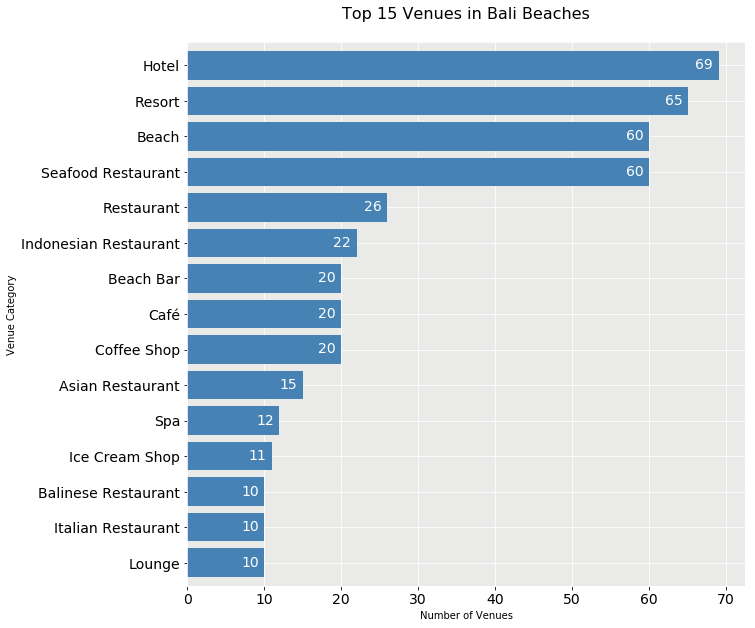

In [71]:
# generate plot
beach_top15.plot(kind='barh', figsize=(10, 10), color='steelblue', width=0.8)
plt.xlabel('Number of Venues')
plt.title('Top 15 Venues in Bali Beaches\n', fontsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

# annotate value labels to each country
for index, value in enumerate(beach_top15): 
    label = format(int(value)) # format int with commas
    
    # place text at the end of bar (subtracting 2 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value - 3, index - 0.10), color='white', fontsize=14)

plt.rcParams['axes.facecolor'] = '#eaeae9'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "white"

plt.savefig('top15_venues_in_bali_beaches.jpg', bbox_inches = "tight")
plt.show()

As you can see above, the category of hotel is in the first place with 69 venues from all of the venues near beaches. Now, let’s specify the exploration to know the number of hotels in each beach. The first step to do is the same as we did in the previous exploration, which is to filter the dataframe which the category is hotel. 

In [72]:
hotel_beach = beach_venues[beach_venues['Venue Category'] == 'Hotel']
print(hotel_beach.shape)
hotel_beach

(69, 7)


,Beach,Beach Latitude,Beach Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,Mercure beach,-8.711357,115.254103,Mercure Resort Sanur Bali,-8.709372,115.253974,Hotel
4,Mercure beach,-8.711357,115.254103,Prama Sanur Beach Hotel,-8.709834,115.256470,Hotel
19,Mercure beach,-8.711357,115.254103,Abian Kokoro,-8.708289,115.257313,Hotel
24,Pantai Mertasari,-8.712437,115.251110,Mercure Resort Sanur Bali,-8.709372,115.253974,Hotel
27,Discovery Beach,-8.727725,115.167094,Discovery Kartika Plaza Hotel,-8.729493,115.166609,Hotel
41,Discovery Beach,-8.727725,115.167094,Amnaya Resort,-8.729642,115.170077,Hotel
49,Discovery Beach,-8.727725,115.167094,favehotel Kuta - Kartika Plaza,-8.730321,115.167634,Hotel
50,Discovery Beach,-8.727725,115.167094,Yan's House Hotel,-8.726546,115.170434,Hotel
51,Discovery Beach,-8.727725,115.167094,Kuta Paradiso Hotel,-8.725699,115.170193,Hotel
54,Discovery Beach,-8.727725,115.167094,Sun Island Hotel Kuta,-8.730638,115.167397,Hotel


The result of filtering, there are not any single hotel in nine beaches, so I manually insert the 0 value for those beaches in order that we can see all of the results. The next step is to count the number of the hotels grouped by the beaches and perform ascending sort order based on it. 

In [94]:
hotel_beach_count = hotel_beach.groupby('Beach')['Venue'].count().reset_index()
hotel_beach_count = hotel_beach_count.append([{'Beach': 'Tegal Wangi Beach', 'Venue': 0}, 
                                           {'Beach': 'Pantai Pandawa', 'Venue': 0},
                                           {'Beach': 'Green Bowl Beach', 'Venue': 0},
                                           {'Beach': 'Kubu Beach', 'Venue': 0},
                                           {'Beach': 'Kelingking Beach', 'Venue': 0},
                                           {'Beach': 'Crystal Bay', 'Venue': 0},
                                           {'Beach': 'Mangrove Beach', 'Venue': 0},
                                           {'Beach': 'Atuh Beach', 'Venue': 0},
                                           {'Beach': 'Diamond Beach', 'Venue': 0},
                                           {'Beach': 'Broken Beach', 'Venue': 0},
                                           {'Beach': 'Karma Private Beach', 'Venue': 0},
                                           {'Beach': 'Segara Beach', 'Venue': 0}])

hotel_beach_count = hotel_beach_count.sort_values(by='Venue', ascending=True)
hotel_beach_count.set_index('Beach', inplace=True)
hotel_beach_count = hotel_beach_count['Venue'].tail(50)
hotel_beach_count

Beach
Segara Beach           0
Broken Beach           0
Diamond Beach          0
Atuh Beach             0
Mangrove Beach         0
Crystal Bay            0
Kelingking Beach       0
Kubu Beach             0
Green Bowl Beach       0
Pantai Pandawa         0
Tegal Wangi Beach      0
Karma Private Beach    0
Pantai Mertasari       1
Pantai Melasti         1
Balangan Beach         1
Four Seasons Beach     1
Pantai Jungutbatu      2
Bingin Beach           2
Dream Beach            2
Dreamland Beach        2
Jimbaran Beach         2
Tanjung Benoa Beach    2
Pemedal Beach          2
Segara Beach           2
Secret Point Beach     2
Sanur Beach            2
Pantai Muaya           2
Mercure beach          3
Pantai Kuta            3
Nusa Dua Beach         3
Canggu Beach           4
Discovery Beach        6
Boardwalk Kuta         6
Seminyak Beach         9
Legian Beach           9
Name: Venue, dtype: int64

Now, let's visualize it

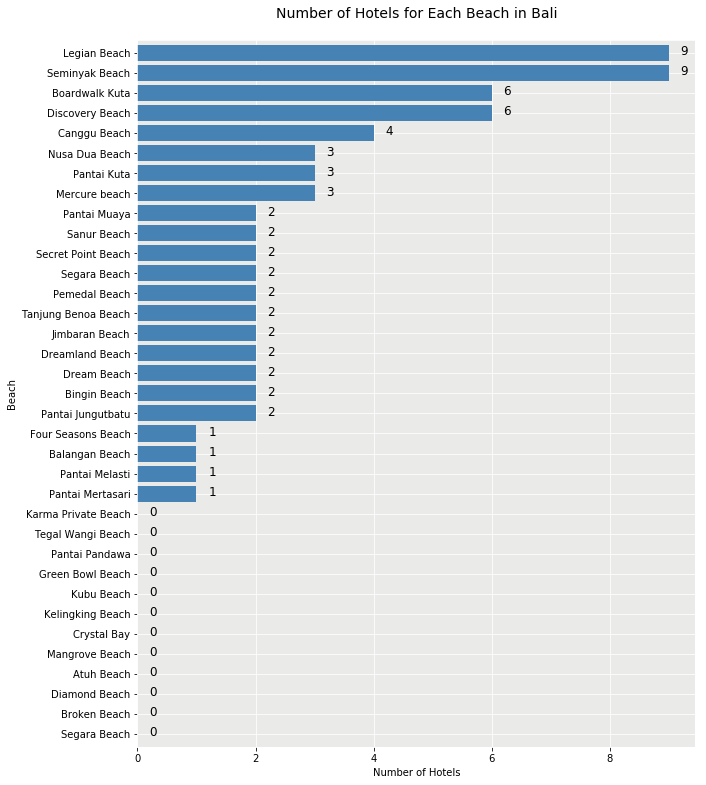

In [95]:
# generate plot
hotel_beach_count.plot(kind='barh', figsize=(10, 13), color='steelblue', width=0.8)
plt.xlabel('Number of Hotels')
plt.title('Number of Hotels for Each Beach in Bali\n', fontsize=14)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

# annotate value labels to each country
for index, value in enumerate(hotel_beach_count): 
    label = format(int(value)) # format int with commas
    
    # place text at the end of bar (subtracting 2 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value + 0.2, index - 0.10), color='black', fontsize=12)

plt.rcParams['axes.facecolor'] = '#eaeae9'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "white"

plt.savefig('number_of_hotels_in_each_beach.jpg', bbox_inches = "tight")
plt.show()

## Clustering beaches

Same as what we have done above, the first step to for clustering beaches in southern Bali is to encode the venue categories using one-hot encoding method.

In [76]:
# one hot encoding
beach_encoding = pd.get_dummies(beach_venues[['Venue Category']], prefix="", prefix_sep="")

# add beach column back to dataframe
beach_encoding['Beach'] = beach_venues['Beach'] 

beach_encoding.head()

,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Balinese Restaurant,Bar,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Shop,Bistro,Boarding House,Boat or Ferry,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Café,Candy Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Dessert Shop,Diner,Dive Shop,Dive Spot,Donut Shop,Eastern European Restaurant,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Food Court,Food Truck,Forest,French Restaurant,Gastropub,General Entertainment,Gourmet Shop,Gym,Hawaiian Restaurant,Hostel,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indonesian Meatball Place,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lounge,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Molecular Gastronomy Restaurant,Movie Theater,Multiplex,New American Restaurant,Nightclub,Pedestrian Plaza,Pizza Place,Pool,Pub,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Snack Place,Spa,Spanish Restaurant,Sports Bar,Steakhouse,Surf Spot,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Wine Shop,Yoga Studio
0,0,0,0,0,0,0,Mercure beach,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,Mercure beach,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,Mercure beach,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,Mercure beach,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,Mercure beach,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:
# move beach to the first column
beach_column = [beach_encoding.columns[6]] + list(beach_encoding.columns[0:6]) + list(beach_encoding.columns[7:])
beach_encoding = beach_encoding[beach_column]
beach_encoding.head()

,Beach,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Balinese Restaurant,Bar,Beach Bar,Bed & Breakfast,Beer Garden,Bike Shop,Bistro,Boarding House,Boat or Ferry,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Café,Candy Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Dessert Shop,Diner,Dive Shop,Dive Spot,Donut Shop,Eastern European Restaurant,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Food Court,Food Truck,Forest,French Restaurant,Gastropub,General Entertainment,Gourmet Shop,Gym,Hawaiian Restaurant,Hostel,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indonesian Meatball Place,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lounge,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Molecular Gastronomy Restaurant,Movie Theater,Multiplex,New American Restaurant,Nightclub,Pedestrian Plaza,Pizza Place,Pool,Pub,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Snack Place,Spa,Spanish Restaurant,Sports Bar,Steakhouse,Surf Spot,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Wine Shop,Yoga Studio
0,Mercure beach,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Mercure beach,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Mercure beach,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Mercure beach,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Mercure beach,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [78]:
beach_encoding.shape

(656, 96)

Once the one-hot encoding dataframe is ready, the next step is to calculate the average or mean for each venue grouped by the beach. 

In [79]:
beach_grouped = beach_encoding.groupby('Beach').mean().reset_index()
beach_grouped

,Beach,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Balinese Restaurant,Bar,Beach Bar,Bed & Breakfast,Beer Garden,Bike Shop,Bistro,Boarding House,Boat or Ferry,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Café,Candy Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Dessert Shop,Diner,Dive Shop,Dive Spot,Donut Shop,Eastern European Restaurant,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Food Court,Food Truck,Forest,French Restaurant,Gastropub,General Entertainment,Gourmet Shop,Gym,Hawaiian Restaurant,Hostel,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indonesian Meatball Place,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lounge,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Molecular Gastronomy Restaurant,Movie Theater,Multiplex,New American Restaurant,Nightclub,Pedestrian Plaza,Pizza Place,Pool,Pub,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Snack Place,Spa,Spanish Restaurant,Sports Bar,Steakhouse,Surf Spot,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Wine Shop,Yoga Studio
0,Atuh Beach,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Balangan Beach,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.400000,0.0,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Bingin Beach,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.200000,0.1,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Blue Point Beach,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.00

In [80]:
beach_grouped.shape

(35, 96)

Then, let's generate the top 5 venues having the highest average scores.

In [82]:
num_top_venues = 5

for beach in beach_grouped['Beach']:
    print("----"+beach+"----")
    temp = beach_grouped[beach_grouped['Beach'] == beach].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Atuh Beach----
                 venue  freq
0  American Restaurant   0.0
1   Mexican Restaurant   0.0
2                  Pub   0.0
3                 Pool   0.0
4          Pizza Place   0.0


----Balangan Beach----
                venue  freq
0              Resort   0.4
1               Hotel   0.2
2  Seafood Restaurant   0.2
3  Mexican Restaurant   0.0
4                Pool   0.0


----Bingin Beach----
        venue  freq
0       Hotel   0.2
1   Juice Bar   0.2
2      Resort   0.2
3   Rest Area   0.1
4  Restaurant   0.1


----Blue Point Beach----
                   venue  freq
0                 Resort  0.27
1              Beach Bar  0.20
2             Restaurant  0.13
3      Convenience Store  0.07
4  General Entertainment  0.07


----Boardwalk Kuta----
                 venue  freq
0                Hotel  0.17
1   Seafood Restaurant  0.06
2           Restaurant  0.06
3       Ice Cream Shop  0.06
4  Japanese Restaurant  0.06


----Broken Beach----
                 venue  freq
0      

This is the 1st to 10th most common venues for each beach

In [83]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Beach']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
beach_venues_sorted = pd.DataFrame(columns=columns)
beach_venues_sorted['Beach'] = beach_grouped['Beach']

for ind in np.arange(beach_grouped.shape[0]):
    beach_venues_sorted.iloc[ind, 1:] = return_most_common_venues(beach_grouped.iloc[ind, :], num_top_venues)

beach_venues_sorted

,Beach,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Atuh Beach,Yoga Studio,Flea Market,Cosmetics Shop,Dessert Shop,Diner,Dive Shop,Dive Spot,Donut Shop,Eastern European Restaurant,Fast Food Restaurant
1,Balangan Beach,Resort,Hotel,Seafood Restaurant,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Dessert Shop,Diner,Dive Shop,Dive Spot
2,Bingin Beach,Hotel,Resort,Juice Bar,Rest Area,Restaurant,Building,Fast Food Restaurant,Cosmetics Shop,Dessert Shop,Diner
3,Blue Point Beach,Resort,Beach Bar,Restaurant,General Entertainment,Indonesian Restaurant,Convenience Store,Breakfast Spot,Yoga Studio,Fast Food Restaurant,Dessert Shop
4,Boardwalk Kuta,Hotel,Restaurant,Japanese Restaurant,Ice Cream Shop,Seafood Restaurant,Cocktail Bar,Mexican Restaurant,Mediterranean Restaurant,Massage Studio,Coffee Shop
5,Broken Beach,Beach Bar,Yoga Studio,Flea Market,Cosmetics Shop,Dessert Shop,Diner,Dive Shop,Dive Spot,Donut Shop,Eastern European Restaurant
6,Canggu Beach,Hotel,Yoga Studio,Restaurant,Balinese Restaurant,Cocktail Bar,Surf Spot,Bed & Breakfast,Beer Garden,Breakfast Spot,Café
7,Crystal Bay,Dive Spot,Yoga Studio,Flea Market,Cosmetics Shop,Dessert Shop,Diner,Dive Shop,Donut Shop,Eastern European Restaurant,Fast Food Restaurant
8,Diamond Beach,Scenic Lookout,Yoga Studio,Comfort Food Restaurant,Cosmetics Shop,Dessert Shop,Diner,Dive Shop,Dive Spot,Donut Shop,Eastern European Restaurant
9,Discovery Beach,Hotel,Ice Cream Shop,Seafood Restaurant,Resort,Mediterranean Restaurant,Café,Shopping Mall,Japanese Restaurant,Mexican Restaurant,Lounge


The most common venues for each beach have created. As we did before, the next step is to cluster the beaches. For the beach clustering, the number of clusters is 5 as we have more than 30 data in the dataframe. 

In [84]:
# set number of clusters
kclusters = 5

beach_clustering = beach_grouped.drop('Beach', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(beach_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 4, 0, 2, 0, 2, 0, 3, 0, 0])

In [85]:
# add clustering labels
beach_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

beach_merged = bali_beach

# merge beach_grouped with beach_venues_sorted to add latitude/longitude for each beach
beach_merged = beach_merged.join(beach_venues_sorted.set_index('Beach'), on='Beach')

beach_merged # check the last columns!

,Beach,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mercure beach,-8.711357,115.254103,0,Restaurant,Hotel,Surf Spot,Indonesian Restaurant,Italian Restaurant,Coffee Shop,Resort,Café,Yoga Studio,Bar
1,Pantai Mertasari,-8.712437,115.251110,0,Yoga Studio,Restaurant,Hotel,Resort,Coffee Shop,General Entertainment,Dive Spot,Hawaiian Restaurant,Gym,Convenience Store
2,Discovery Beach,-8.727725,115.167094,0,Hotel,Ice Cream Shop,Seafood Restaurant,Resort,Mediterranean Restaurant,Café,Shopping Mall,Japanese Restaurant,Mexican Restaurant,Lounge
3,Boardwalk Kuta,-8.727078,115.167793,0,Hotel,Restaurant,Japanese Restaurant,Ice Cream Shop,Seafood Restaurant,Cocktail Bar,Mexican Restaurant,Mediterranean Restaurant,Massage Studio,Coffee Shop
4,Pantai Kuta,-8.718751,115.169037,0,Coffee Shop,Hotel,Clothing Store,Restaurant,Café,Resort,Balinese Restaurant,Italian Restaurant,Surf Spot,Convenience Store
5,Pantai Muaya,-8.781143,115.163808,1,Seafood Restaurant,Resort,Pool,Lounge,French Restaurant,Hotel,Spa,Beach Bar,Coffee Shop,Pizza Place
6,Four Seasons Beach,-8.782794,115.161406,1,Seafood Restaurant,Resort,Asian Restaurant,French Restaurant,Spa,Ice Cream Shop,Beach Bar,Lounge,Pizza Place,Pedestrian Plaza
7,Pantai Melasti,-8.848288,115.160215,0,Resort,Asian Restaurant,Hotel,Diner,New American Restaurant,Café,Yoga Studio,Fast Food Restaurant,Dessert Shop,Dive Shop
8,Tegal Wangi Beach (Pantai Tegal Wangi),-8.782205,115.140860,4,Resort,Pool,Cocktail Bar,Breakfast Spot,Dessert Shop,Tea Room,Italian Restaurant,Convenience Store,Cosmetics Shop,Diner
9,Pantai Pandawa,-8.845491,115.185822,0,Café,Resort,Vacation Rental,Beach Bar,Yoga Studio,Fish & Chips Shop,Cosmetics Shop,Dessert Shop,Diner,Dive Shop


Now, let's visualize the result of clustering process using Folium

In [93]:
from folium.plugins import FastMarkerCluster

# create map
map_clusters = folium.Map(location=[sanur_latitude, sanur_longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = ['#fa080c', '#0817fa', '#fa7208', '#60fb2a', '#f608fa']


# add markers to the map
markers_colors = []
for lat, lon, point, cluster in zip(beach_merged['Latitude'], beach_merged['Longitude'], beach_merged['Beach'], beach_merged['Cluster Labels']):
    label = folium.Popup(str(point) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors_array[cluster],
        fill=True,
        fill_color=colors_array[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('beach_clustering_map.html')
map_clusters

Members of cluster label 0

In [87]:
beach_cluster0 = beach_merged.loc[beach_merged['Cluster Labels'] == 0, beach_merged.columns[[0,3] + list(range(4, beach_merged.shape[1]))]]
beach_cluster0

,Beach,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mercure beach,0,Restaurant,Hotel,Surf Spot,Indonesian Restaurant,Italian Restaurant,Coffee Shop,Resort,Café,Yoga Studio,Bar
1,Pantai Mertasari,0,Yoga Studio,Restaurant,Hotel,Resort,Coffee Shop,General Entertainment,Dive Spot,Hawaiian Restaurant,Gym,Convenience Store
2,Discovery Beach,0,Hotel,Ice Cream Shop,Seafood Restaurant,Resort,Mediterranean Restaurant,Café,Shopping Mall,Japanese Restaurant,Mexican Restaurant,Lounge
3,Boardwalk Kuta,0,Hotel,Restaurant,Japanese Restaurant,Ice Cream Shop,Seafood Restaurant,Cocktail Bar,Mexican Restaurant,Mediterranean Restaurant,Massage Studio,Coffee Shop
4,Pantai Kuta,0,Coffee Shop,Hotel,Clothing Store,Restaurant,Café,Resort,Balinese Restaurant,Italian Restaurant,Surf Spot,Convenience Store
7,Pantai Melasti,0,Resort,Asian Restaurant,Hotel,Diner,New American Restaurant,Café,Yoga Studio,Fast Food Restaurant,Dessert Shop,Dive Shop
9,Pantai Pandawa,0,Café,Resort,Vacation Rental,Beach Bar,Yoga Studio,Fish & Chips Shop,Cosmetics Shop,Dessert Shop,Diner,Dive Shop
10,Greenbowl Beach,0,Yoga Studio,Flea Market,Cosmetics Shop,Dessert Shop,Diner,Dive Shop,Dive Spot,Donut Shop,Eastern European Restaurant,Fast Food Restaurant
13,Kelingking Beach,0,Balinese Restaurant,Scenic Lookout,Comfort Food Restaurant,Yoga Studio,Fish & Chips Shop,Cosmetics Shop,Dessert Shop,Diner,Dive Shop,Dive Spot
16,Atuh Beach,0,Yoga Studio,Flea Market,Cosmetics Shop,Dessert Shop,Diner,Dive Shop,Dive Spot,Donut Shop,Eastern European Restaurant,Fast Food Restaurant


Member of cluster label 1

In [88]:
beach_cluster1 = beach_merged.loc[beach_merged['Cluster Labels'] == 1, beach_merged.columns[[0,3] + list(range(4, beach_merged.shape[1]))]]
beach_cluster1

,Beach,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Pantai Muaya,1,Seafood Restaurant,Resort,Pool,Lounge,French Restaurant,Hotel,Spa,Beach Bar,Coffee Shop,Pizza Place
6,Four Seasons Beach,1,Seafood Restaurant,Resort,Asian Restaurant,French Restaurant,Spa,Ice Cream Shop,Beach Bar,Lounge,Pizza Place,Pedestrian Plaza
27,Jimbaran Beach,1,Seafood Restaurant,Resort,Pool,Beach Bar,Coffee Shop,Lounge,Spa,Hotel,French Restaurant,Food Truck


Member of cluster label 2

In [89]:
beach_cluster2 = beach_merged.loc[beach_merged['Cluster Labels'] == 2, beach_merged.columns[[0,3] + list(range(4, beach_merged.shape[1]))]]
beach_cluster2

,Beach,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Kubu Beach,2,Resort,Beach Bar,Breakfast Spot,Yoga Studio,Flea Market,Dessert Shop,Diner,Dive Shop,Dive Spot,Donut Shop
22,Broken Beach,2,Beach Bar,Yoga Studio,Flea Market,Cosmetics Shop,Dessert Shop,Diner,Dive Shop,Dive Spot,Donut Shop,Eastern European Restaurant
28,Blue Point Beach,2,Resort,Beach Bar,Restaurant,General Entertainment,Indonesian Restaurant,Convenience Store,Breakfast Spot,Yoga Studio,Fast Food Restaurant,Dessert Shop


Member of cluster label 3

In [90]:
beach_cluster3 = beach_merged.loc[beach_merged['Cluster Labels'] == 3, beach_merged.columns[[0,3] + list(range(4, beach_merged.shape[1]))]]
beach_cluster3

,Beach,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Crystal Bay,3,Dive Spot,Yoga Studio,Flea Market,Cosmetics Shop,Dessert Shop,Diner,Dive Shop,Donut Shop,Eastern European Restaurant,Fast Food Restaurant
15,Mangrove Beach,3,Balinese Restaurant,Dive Spot,Forest,Yoga Studio,Flea Market,Cosmetics Shop,Dessert Shop,Diner,Dive Shop,Donut Shop


Member of cluster label 4

In [91]:
beach_cluster4 = beach_merged.loc[beach_merged['Cluster Labels'] == 4, beach_merged.columns[[0,3] + list(range(4, beach_merged.shape[1]))]]
beach_cluster4

,Beach,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Tegal Wangi Beach (Pantai Tegal Wangi),4,Resort,Pool,Cocktail Bar,Breakfast Spot,Dessert Shop,Tea Room,Italian Restaurant,Convenience Store,Cosmetics Shop,Diner
12,Karma Private Beach,4,Resort,Indonesian Restaurant,Beach Bar,Spa,Mediterranean Restaurant,Yoga Studio,Fast Food Restaurant,Cosmetics Shop,Dessert Shop,Diner
29,Balangan Beach,4,Resort,Hotel,Seafood Restaurant,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Dessert Shop,Diner,Dive Shop,Dive Spot


## Result and Discussion

In the exploring and analyzing stage of the districts in south Bali, Indonesian restaurant stands in the first place of the most common venues with having total number of 79 venues for all around the 9 districts. The second place is the hotel with 55 venues followed by resort, coffee shop, and café in the third, fourth, and fifth in order. 

For counting the number of hotels in each district, Kuta has the most number of hotels with 18 hotels, while Kuta Utara follows in the second most number of hotels with 12 hotels around the district. As we see above, there are two districts which do not have any hotel, which are Kediri and Denpasar Utara. 

From the map above describing each cluster, the purple circles define the cluster label 0, the red circles define the cluster label 1, and the green circles define the cluster label 2. As we saw in the result section, the cluster label 0, which is the district with the purple circles, have much more hotel than two other cluster labels. The districts are in it are Denpasar Selatan, Kuta, and Kuta Utara. Based on the chart shown in above, those three districts are in the top 3 based on the number of hotels.

The two other clusters, the red circles and the green circles, do not have many hotels. Both Denpasar Utara and Kediri, which do not have any hotel at all, become parts of cluster label 2, the green circles, as those two districts have many restaurants as the 1st most common venues like the other member in that cluster, which are Denpasar Barat and Denpasar Timur. For the cluster label 1, the red circles, the 1st and 2nd most common venue in those two districts is resort and beach. As we know, the resort is somewhat similar to the hotel but it has a little bit of difference in facilities and services. 

Now, let’s assume that the new hotel must near a beach as Bali is popular with its beautiful beach so that it likely will get more visitors than other places. Regarding the exploration we had before, let’s take a look at the chart we have made.

As we can see in the chart above, hotel is in the first place of the most common venues with 69 venues. It can be said that the hotel is the most important venue near a beach as the tourists who come to Bali definitely visit the beaches and they prefer to stay near a beach.

From 69 hotels, the most are in Legian Beach and Seminyak Beach. It is not surprising as those two beaches are the most popular in Bali. It turns out that there are still some beaches which do not have any hotel at all.

From the map above describing each beach, the pink circles define the cluster label 0, the red circles define the cluster label 1, the blue circles define the cluster label 2, the orange circles define the cluster label 3, and the green circles define the cluster label 4. As we saw in the result section, the cluster label 0, have more hotels than four other cluster labels. Legian Beach, Seminyak Beach, Broadwalk Kuta, Discovery Beach, Canggu Beach, Tanjung Benoa Beach, Pantai Kuta, and Nusa Dua Beach, which are in the top 8 beach in number of hotels, are members of that cluster.

Cluster labels 1, 2, and 4, the red, blue, and green circles in order, have fewer hotels than cluster label 0, but they have many resort which is similar to hotel with somewhat different facilities and services. Meanwhile, as we saw in Figure 18 in the Result section, the beaches in cluster label 3 do not have any hotel or resort in their 1st to 10th most common venues.

## Conclusion

Purpose of this project is to identify the areas in Bali with low number of hotels in order to help stakeholders in searching for optimal location to build a new hotel in Bali. After exploring the venues in south Bali using Foursquare data, we can conclude some of the points in the following.

1.	The best location for a new hotel in south Bali if no more criteria have to be required is in districts which are parts of cluster label 2, especially Kediri district in Tabanan regency or Denpasar Utara in Denpasar which has no any single hotel.
2.	The best location for a new hotel near a beach in southern Bali is in the beaches of the cluster label 3 members, which are Crystal Bay and Mangrove Beach. 
3.	The other choices are on the beaches which do not have any hotel yet or the beaches which have only one hotel.

The final decision will be made by stakeholders by considering all aspects required.

This exploration result depends on the time you access. This project used Foursquare, where the data will be probably changed because of the additional venues or other possibilities.
